In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
)
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

In [2]:
!pip install imbalanced-learn

In [3]:
df = pd.read_csv("y_2020.csv")

/var/folders/pk/lf6l0f7j4sqg3_2178k28s080000gn/T/ipykernel_35107/1465085523.py:1: DtypeWarning: Columns (1,2,5,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("y_2020.csv")


In [4]:
df.info()
df.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198745 entries, 0 to 198744
Data columns (total 23 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   C_YEAR  198745 non-null  int64 
 1   C_MNTH  198745 non-null  object
 2   C_WDAY  198745 non-null  object
 3   C_HOUR  198745 non-null  object
 4   C_SEV   198745 non-null  int64 
 5   C_VEHS  198745 non-null  object
 6   C_CONF  198745 non-null  object
 7   C_RCFG  198745 non-null  object
 8   C_WTHR  198745 non-null  object
 9   C_RSUR  198745 non-null  object
 10  C_RALN  198745 non-null  object
 11  C_TRAF  198745 non-null  object
 12  V_ID    198745 non-null  object
 13  V_TYPE  198745 non-null  object
 14  V_YEAR  198745 non-null  object
 15  P_ID    198745 non-null  object
 16  P_SEX   198745 non-null  object
 17  P_AGE   198745 non-null  object
 18  P_PSN   198745 non-null  object
 19  P_ISEV  198745 non-null  object
 20  P_SAFE  198745 non-null  object
 21  P_USER  198745 non-null  object
 

C_YEAR    0
C_MNTH    0
C_WDAY    0
C_HOUR    0
C_SEV     0
C_VEHS    0
C_CONF    0
C_RCFG    0
C_WTHR    0
C_RSUR    0
C_RALN    0
C_TRAF    0
V_ID      0
V_TYPE    0
V_YEAR    0
P_ID      0
P_SEX     0
P_AGE     0
P_PSN     0
P_ISEV    0
P_SAFE    0
P_USER    0
C_CASE    0
dtype: int64

In [5]:
# Drop ID and year columns
drop_cols = ['C_YEAR', 'V_ID', 'P_ID', 'C_CASE']
df = df.drop(columns=drop_cols, errors='ignore')

In [6]:
from sklearn.model_selection import train_test_split

y = df['P_ISEV']
X = df.drop(columns=['P_ISEV'])

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train size: {X_train.shape}")
print(f"Validation size: {X_val.shape}")
print(f"Test size: {X_test.shape}")

Train size: (119247, 18)
Validation size: (39749, 18)
Test size: (39749, 18)


In [7]:
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numeric_cols = ['V_YEAR'] 

def replace_fake_missing(df):
    df = df.copy()
    fake_missing_values = ['UU', 'XX', 'U', 'X', 'N', 'NN', 'QQ', 'UUUU', 'XXXX' '*', '**']
    df = df.replace(fake_missing_values, np.nan)
    return df

X_train = replace_fake_missing(X_train)
X_val = replace_fake_missing(X_val)
X_test = replace_fake_missing(X_test)

for col in numeric_cols:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
    
for col in categorical_cols:
    X_train[col] = X_train[col].astype(str)
    X_val[col] = X_val[col].astype(str)
    X_test[col] = X_test[col].astype(str)

In [8]:
X_train.head(10)

,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,V_YEAR,P_SEX,P_AGE,P_PSN,P_SAFE,P_USER
167641,11,1,11,2,2,21,01,1,1,1,18,01,2018.0,M,51,23,02,2
139525,9,4,18,1,02,22,02,1,1,1,01,01,2005.0,F,66,11,02,1
174380,11,4,12,2,2,21,01,1,1,1,18,08,2013.0,M,63,11,02,1
160379,10,5,14,2,02,36,02,1,1,1,18,01,2019.0,nan,nan,11,nan,1
79036,6,2,08,2,1,34,02,1,1,2,02,nan,nan,M,68,99,nan,3
1839,1,1,09,2,01,06,01,1,3,1,18,01,2017.0,M,69,11,nan,1
154671,10,3,13,2,02,36,01,2,1,1,01,01,2001.0,M,38,11,02,1
7621,1,3,07,2,02,35,02,1,2,1,01,01,2017.0,F,24,11,02,1
165837,10,7,02,2,2,22,01,1,1,1,nan,nan,nan,nan,nan,11,nan,nan
187083,12,2,17,2,2,21,01,1,1,1,18,01,2020.0,M,34,11,02,1


In [9]:
fake_y_values = ['N', 'U', 'X']

y_train = y_train.replace(fake_y_values, np.nan)
y_val = y_val.replace(fake_y_values, np.nan)
y_test = y_test.replace(fake_y_values, np.nan)

X_train = X_train[y_train.notna()]
y_train = y_train[y_train.notna()]

X_val = X_val[y_val.notna()]
y_val = y_val[y_val.notna()]

X_test = X_test[y_test.notna()]
y_test = y_test[y_test.notna()]

In [10]:
pseudo_numeric = ['P_AGE', 'P_PSN', 'C_VEHS']
numeric_cols += pseudo_numeric

all_object_cols = X_train.select_dtypes(include='object').columns.tolist()

categorical_cols = list(set(all_object_cols) - set(pseudo_numeric))

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
])

# First version of model:

In [12]:
from sklearn.linear_model import LogisticRegression

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        l1_ratio=0.5,
        multi_class='multinomial',
        max_iter=1000
))
])

In [13]:
model.fit(X_train, y_train)

/opt/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['V_YEAR', 'P_AGE', 'P_PSN',
                                                   'C_VEHS']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['C_CONF', 'C_RCFG', 'V_TYPE',
                                                   'C_MNTH', 'C_HOUR', 'P_SAFE',
                                                   'P_USER', 'C_RALN', 'V_YEAR',
                                                   'C_WTHR', 'C_RSUR', 'C_WDAY',
                                                   'C_TRAF', 'P_SEX'])])),
                ('classifier',
                 LogisticRegression(l1_ratio=0.5, max_iter=1000,
                                    multi_class='multinomial',
                                    penalty='elasticnet', solver='saga'))])

In [14]:
# Extract non-zero coefficients to analyze feature importance

# Extract feature names after preprocessing + get model coefficients
coefs = model.named_steps['classifier'].coef_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
# For each class, get non-zero coefficients and their corresponding features
for class_index, class_coef in enumerate(coefs):
    print(f"\nTop features for class {class_index + 1}:")
    
    non_zero_idx = class_coef != 0
    important_features = [(feature_names[i], class_coef[i]) for i in range(len(class_coef)) if non_zero_idx[i]]
    important_features = sorted(important_features, key=lambda x: abs(x[1]), reverse=True)
    
    for feature, coef in important_features[:15]:  # Show top 15
        print(f"{feature}: {coef:.4f}")


Top features for class 1:
cat__P_USER_3: -2.6308
cat__V_TYPE_22: -1.5820
cat__V_TYPE_09: 1.4966
cat__C_CONF_03: -1.2169
cat__V_TYPE_16: -1.2130
cat__P_USER_2: 1.2091
cat__C_CONF_04: -1.1600
cat__P_USER_nan: 1.1049
cat__P_SAFE_nan: 1.0654
cat__P_USER_1: 1.0458
cat__V_YEAR_1985.0: -0.8635
cat__C_CONF_05: -0.7952
cat__P_SEX_nan: 0.7885
cat__C_RCFG_04: -0.7559
cat__P_SAFE_01: -0.7536

Top features for class 2:
cat__P_USER_3: 1.3296
cat__V_TYPE_17: 1.0685
cat__P_USER_4: 1.0685
cat__C_RSUR_8: 1.0282
cat__P_SEX_F: 0.9631
cat__V_YEAR_1978.0: 0.9486
cat__C_RSUR_7: 0.7898
cat__P_SAFE_12: 0.6503
cat__C_TRAF_05: 0.5496
cat__V_YEAR_1979.0: -0.5244
cat__V_YEAR_1966.0: 0.5136
cat__C_TRAF_15: -0.5113
cat__V_YEAR_1954.0: -0.4963
cat__P_SEX_M: 0.4867
cat__V_YEAR_1986.0: 0.4826

Top features for class 3:
cat__P_SEX_nan: -1.8772
cat__V_TYPE_11: -1.6806
cat__P_SAFE_12: -1.5976
cat__P_SAFE_02: -1.5177
cat__C_CONF_31: 1.4330
cat__C_CONF_34: -1.3275
cat__C_TRAF_04: -1.2706
cat__V_YEAR_1954.0: 1.2266
cat__C_T

Train Accuracy: 0.6804442210136649
Validation Accuracy: 0.6815838543380498

Classification Report (Validation Set):
              precision    recall  f1-score   support

           1       0.65      0.57      0.61     15266
           2       0.70      0.77      0.74     20853
           3       0.00      0.00      0.00       349

    accuracy                           0.68     36468
   macro avg       0.45      0.45      0.45     36468
weighted avg       0.67      0.68      0.67     36468



<Figure size 600x600 with 0 Axes>

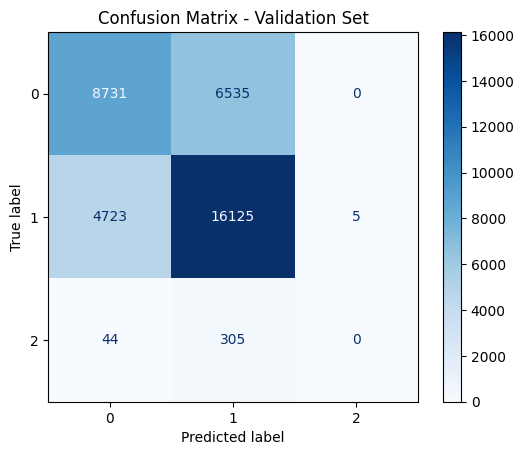

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_val_pred = model.predict(X_val)

print("Train Accuracy:", model.score(X_train, y_train))
print("Validation Accuracy:", model.score(X_val, y_val))

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Validation Set")
plt.show()

In [16]:
print("Train Accuracy:", model.score(X_train, y_train))
print("Validation Accuracy:", model.score(X_val, y_val))

Train Accuracy: 0.6804442210136649
Validation Accuracy: 0.6815838543380498


# Second Version of model:

In [17]:
X_train_processed = preprocessor.fit_transform(X_train)

In [18]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)

In [19]:
from sklearn.linear_model import LogisticRegression

model_smote = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5,
    max_iter=1000
)

model_smote.fit(X_resampled, y_resampled)

LogisticRegression(l1_ratio=0.5, max_iter=1000, penalty='elasticnet',
                   solver='saga')

In [20]:
# Extract non-zero coefficients to analyze feature importance

# Extract feature names after preprocessing + get model coefficients
coefs = model_smote.coef_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

# For each class, get non-zero coefficients and their corresponding features
for class_index, class_coef in enumerate(coefs):
    print(f"\nTop features for class {class_index + 1}:")
    
    non_zero_idx = class_coef != 0
    important_features = [(feature_names[i], class_coef[i]) for i in range(len(class_coef)) if non_zero_idx[i]]
    important_features = sorted(important_features, key=lambda x: abs(x[1]), reverse=True)
    
    for feature, coef in important_features[:15]:  # Show top 15
        print(f"{feature}: {coef:.4f}")


Top features for class 1:
cat__P_USER_3: -2.9329
cat__V_TYPE_09: 2.1972
cat__V_TYPE_22: -2.0195
cat__V_TYPE_11: 1.8397
cat__C_CONF_34: 1.8251
cat__V_TYPE_16: -1.6432
cat__V_YEAR_1954.0: -1.3211
cat__C_CONF_03: -1.2927
cat__C_CONF_04: -1.2849
cat__P_USER_nan: 1.2729
cat__P_USER_2: 1.2594
cat__P_SAFE_nan: 1.2357
cat__C_TRAF_16: -1.2290
cat__P_USER_1: 1.2228
cat__P_SEX_nan: 1.1962

Top features for class 2:
cat__V_YEAR_1969.0: -2.7077
cat__V_YEAR_1954.0: -2.3171
cat__C_RSUR_8: 2.1229
cat__V_YEAR_1978.0: 1.7919
cat__V_YEAR_1932.0: -1.4633
cat__V_TYPE_11: 1.4441
cat__C_TRAF_15: -1.4167
cat__C_CONF_34: 1.3283
cat__V_YEAR_1986.0: 1.3098
cat__C_RALN_Q: 1.1719
cat__C_TRAF_11: 1.1716
cat__C_TRAF_05: 1.1521
cat__P_USER_3: 1.0902
cat__V_YEAR_1966.0: 1.0612
cat__C_RSUR_7: 1.0402

Top features for class 3:
cat__V_YEAR_1954.0: 4.2170
cat__V_TYPE_11: -3.8621
cat__C_CONF_34: -3.7322
cat__V_YEAR_1969.0: 3.6279
cat__V_TYPE_09: -3.2990
cat__C_TRAF_15: 2.8391
cat__C_TRAF_04: -2.6539
cat__P_SEX_nan: -2.648

              precision    recall  f1-score   support

           1       0.60      0.71      0.65     15266
           2       0.73      0.47      0.57     20853
           3       0.05      0.69      0.09       349

    accuracy                           0.57     36468
   macro avg       0.46      0.62      0.44     36468
weighted avg       0.67      0.57      0.60     36468



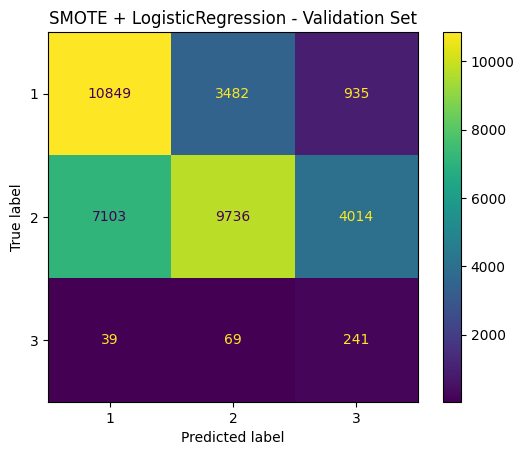

In [21]:
X_val_processed = preprocessor.transform(X_val)

y_val_pred = model_smote.predict(X_val_processed)

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(classification_report(y_val, y_val_pred))

ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)
plt.title("SMOTE + LogisticRegression - Validation Set")
plt.show()

In [22]:
print("Train Accuracy:", model_smote.score(X_resampled, y_resampled))
print("Validation Accuracy:", model_smote.score(X_val_processed, y_val))

Train Accuracy: 0.6697357694336546
Validation Accuracy: 0.571076011846002


# Third Version of model:

In [23]:
# Use a pure L1-regularized logistic regression model to observe sparsity

from sklearn.linear_model import LogisticRegression

# Create and fit a pure L1 logistic regression model
model_l1 = LogisticRegression(
    penalty='l1',
    solver='saga',
    multi_class='multinomial',
    max_iter=1000,
    C=1.0  # smaller C makes regularization stronger
)

model_l1.fit(X_resampled, y_resampled)

/opt/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', penalty='l1',
                   solver='saga')

In [24]:
# Extract non-zero coefficients to analyze feature importance

# Extract feature names after preprocessing + get model coefficients
feature_names = preprocessor.get_feature_names_out()
 
coefs = model_l1.coef_  # shape: (n_classes, n_features)

# For each class, get non-zero coefficients and their corresponding features
for class_index, class_coef in enumerate(coefs):
    print(f"\nTop features for class {class_index + 1}:")
    
    non_zero_idx = class_coef != 0
    important_features = [(feature_names[i], class_coef[i]) for i in range(len(class_coef)) if non_zero_idx[i]]
    important_features = sorted(important_features, key=lambda x: abs(x[1]), reverse=True)
    
    for feature, coef in important_features[:15]:  # Show top 15
        print(f"{feature}: {coef:.4f}")


Top features for class 1:
cat__P_USER_3: -3.5588
cat__V_TYPE_22: -2.1183
cat__V_TYPE_09: 1.9284
cat__V_TYPE_16: -1.7619
cat__V_TYPE_11: 1.6257
cat__C_CONF_34: 1.5663
cat__C_CONF_04: -1.4437
cat__C_CONF_03: -1.3764
cat__P_USER_2: 1.2756
cat__P_SAFE_nan: 1.2259
cat__V_YEAR_1970.0: 1.1785
cat__P_USER_nan: 1.1709
cat__P_USER_1: 1.1201
cat__V_TYPE_14: -1.1050
cat__P_USER_5: -1.1050

Top features for class 2:
cat__C_RSUR_8: 2.7093
cat__V_YEAR_1969.0: -2.6646
cat__V_YEAR_1978.0: 2.2977
cat__V_YEAR_1954.0: -2.2492
cat__V_YEAR_1932.0: -1.6180
cat__V_TYPE_11: 1.2387
cat__C_CONF_34: 1.1507
cat__V_YEAR_1966.0: 1.1309
cat__C_RSUR_7: 1.0868
cat__C_MNTH_nan: -1.0694
cat__C_WDAY_nan: -1.0694
cat__V_YEAR_1979.0: -1.0107
cat__V_YEAR_1986.0: 0.9631
cat__C_TRAF_15: -0.9563
cat__V_YEAR_1982.0: 0.8436

Top features for class 3:
cat__V_YEAR_1954.0: 5.3514
cat__V_TYPE_11: -4.8697
cat__C_CONF_34: -4.7223
cat__V_YEAR_1969.0: 4.4380
cat__V_TYPE_09: -4.1231
cat__C_TRAF_15: 3.3216
cat__C_TRAF_04: -3.2956
cat__P_S

              precision    recall  f1-score   support

           1       0.60      0.71      0.65     15266
           2       0.73      0.47      0.57     20853
           3       0.05      0.69      0.09       349

    accuracy                           0.57     36468
   macro avg       0.46      0.62      0.44     36468
weighted avg       0.67      0.57      0.60     36468



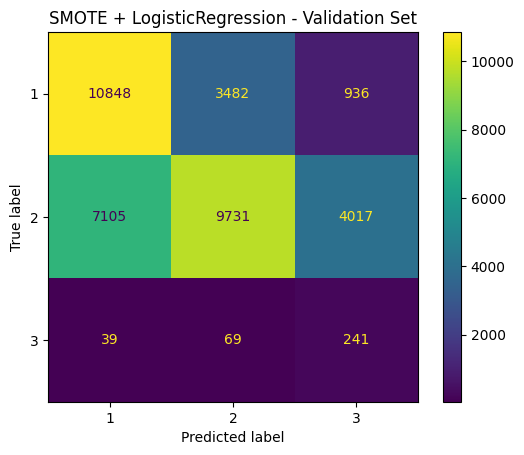

Train Accuracy: 0.6697091279165801
Validation Accuracy: 0.5709114840408029


In [25]:
X_val_processed = preprocessor.transform(X_val)

y_val_pred = model_l1.predict(X_val_processed)

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(classification_report(y_val, y_val_pred))

ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)
plt.title("SMOTE + LogisticRegression - Validation Set")
plt.show()

print("Train Accuracy:", model_l1.score(X_resampled, y_resampled))
print("Validation Accuracy:", model_l1.score(X_val_processed, y_val))

# Fourth Version of model:

In [26]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

df_second = pd.read_csv("y_2020.csv")

# Filter the dataset to keep only two classes: P_ISEV = 1 or 2
df_second = df_second[df_second['P_ISEV'].isin(['1', '2'])]  # If needed, switch to ['2', '3'] for other binary tasks
df_second['target'] = df_second['P_ISEV'].astype(int)
# Optionally re-label: 0 = minor, 1 = serious
# df['target'] = df['P_ISEV'].apply(lambda x: 0 if x == '1' else 1)

# Select relevant features
selected_features = ['C_MNTH','C_WDAY','C_HOUR','C_SEV','C_VEHS','C_CONF','C_RCFG',
                     'C_WTHR','C_RSUR','C_RALN','C_TRAF','V_TYPE','V_YEAR','P_SEX',
                     'P_AGE','P_PSN','P_SAFE','P_USER']

X = df_second[selected_features]
y = df_second['target']

for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype(str)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define preprocessing for numeric and categorical features
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(exclude='object').columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_cols),
    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols)
])

# Build the pipeline with logistic regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', max_iter=1000, solver='lbfgs'))
])

# Train and evaluate the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

/var/folders/pk/lf6l0f7j4sqg3_2178k28s080000gn/T/ipykernel_35107/4052125092.py:10: DtypeWarning: Columns (1,2,5,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_second = pd.read_csv("y_2020.csv")
/var/folders/pk/lf6l0f7j4sqg3_2178k28s080000gn/T/ipykernel_35107/4052125092.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(str)
/var/folders/pk/lf6l0f7j4sqg3_2178k28s080000gn/T/ipykernel_35107/4052125092.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Accuracy: 0.6985880398671096
              precision    recall  f1-score   support

           1       0.66      0.58      0.62     15267
           2       0.72      0.79      0.75     20853

    accuracy                           0.70     36120
   macro avg       0.69      0.68      0.68     36120
weighted avg       0.70      0.70      0.69     36120



# Trying Future Improvement:

In [27]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

tree_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=15,          min_samples_leaf=200,
        random_state=42
    ))
])

# Train the model
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)

# Evaluate
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Decision Tree Accuracy: 0.6922480620155039
              precision    recall  f1-score   support

           1       0.63      0.66      0.65     15267
           2       0.74      0.71      0.73     20853

    accuracy                           0.69     36120
   macro avg       0.69      0.69      0.69     36120
weighted avg       0.69      0.69      0.69     36120



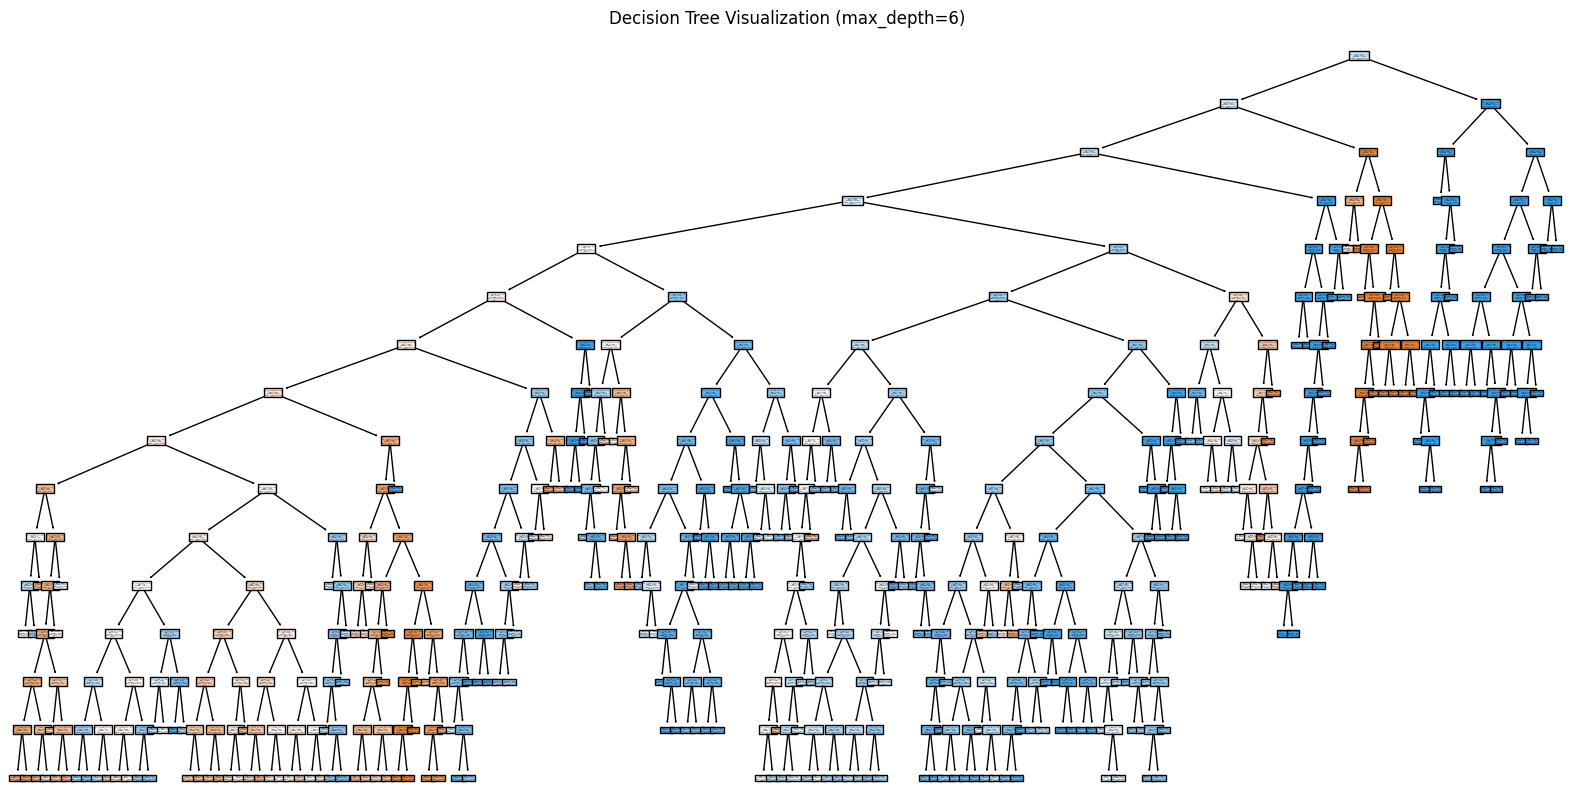

In [28]:
clf = tree_model.named_steps['classifier']

# Fit preprocessing on full dataset for consistent feature names
X_preprocessed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=feature_names, class_names=['1', '2'], filled=True)
plt.title("Decision Tree Visualization (max_depth=6)")
plt.show()

## Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Because we've already do some changeds on categorical columns in previous models before, we need to do some steps on data before we 
# start training model


# Force all categorical columns to be strings
for col in categorical_cols:
    X_train[col] = X_train[col].astype(str)
    X_val[col] = X_val[col].astype(str)

# Check for mixed data types in categorical columns
for col in categorical_cols:
    unique_types = set(type(v) for v in X_train[col].dropna().unique())
    if len(unique_types) > 1:
        print(f"⚠️ Column {col} has mixed types: {unique_types}")



# Construct pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))
])

# Training model
rf_pipeline.fit(X_train, y_train)

# Prediction
y_val_pred = rf_pipeline.predict(X_val)

print("Validation Accuracy:", rf_pipeline.score(X_val, y_val))
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))


Validation Accuracy: 0.6677635187013272

Classification Report (Validation Set):


/opt/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.66      0.48      0.55     15266
           2       0.67      0.82      0.74     20853
           3       0.00      0.00      0.00       349

    accuracy                           0.67     36468
   macro avg       0.44      0.43      0.43     36468
weighted avg       0.66      0.67      0.65     36468


Confusion Matrix:
[[ 7281  7985     0]
 [ 3782 17071     0]
 [   21   328     0]]


In [37]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


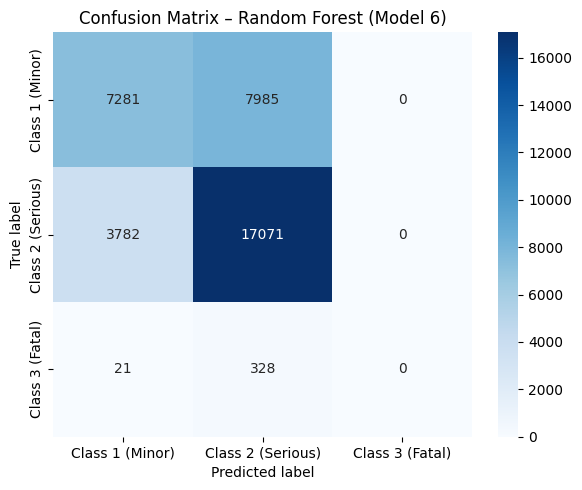

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = np.array([
    [7281, 7985, 0],
    [3782, 17071, 0],
    [21, 328, 0]
])

labels = ['Class 1 (Minor)', 'Class 2 (Serious)', 'Class 3 (Fatal)']

plt.figure(figsize=(6, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix – Random Forest (Model 6)")
plt.xlabel("Predicted label")
plt.ylabel("True label")

plt.tight_layout()

plt.show()


### Model 6: Random Forest Classifier

To evaluate the potential of non-linear methods, we implemented a Random Forest classifier using the same preprocessing pipeline as the previous models. This model serves as a benchmark to test whether ensemble-based learners can perform better than linear models (e.g. logistic regression) in handling complex feature interactions and improving class-wise performance.

The Random Forest was trained with 100 trees and a max depth of 10 to prevent overfitting. All hyperparameters were kept relatively simple to focus on structural performance rather than tuning. The model was evaluated on the validation set without using any resampling or reweighting techniques.

### Results

The model reached an overall validation accuracy of **66.8%**, with strong recall for Class 2 (serious injury, **82%**) and modest performance for Class 1 (minor injury, recall **48%**). However, similar to previous models, it completely failed to predict any Class 3 (fatality) cases—resulting in a **0% recall and F1-score** for that class.

The confusion matrix clearly reflects this limitation: all 349 fatality cases were misclassified as either Class 1 or 2. This confirms that despite being a more flexible model, Random Forests do not inherently fix class imbalance issues unless paired with strategies like oversampling or binary reformulation.

Overall, the Random Forest helps emphasize a key insight in our project: **model complexity alone does not guarantee better performance on rare classes**. In imbalanced datasets like ours, addressing the data distribution is often more impactful than increasing model capacity.
